<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/DL_quest/cv_with_dl/9_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Segmentation

**학습 목표**

* Segmentation의 목표를 이해하고, semantic segmentation과 instance segmentation의 차이점을 설명할 수 있습니다.
* U-Net 모델을 직접 코드로 구현해 보고 다시 한번 Semantic Segmentation 이해하고 Encoder-Decoder 구조를 알아봅시다.

**Q. Segmentation는 어떤 task 인지 설명해 보세요.**
```
이미지를 픽셀 단위로 나누어서 특정 픽셀이 무엇을 지칭하는지를 파악
```

**Q. Semantic Segmentation과 Instance Segmentation 어떤 차이가 있는지 각 개념을 설명해 보세요.**
```
semantic segmentation은 하나의 이미지 안에 들어있는 객체의 종류(object category)를 픽셀 단위로 찾습니다. 반면 instance segmentation은 하나의 이미지 안에 들어있는 객체의 개체(object instance)를 픽셀 단위로 찾습니다.

어떤 Segmentation 종류이든 이미지 데이터를 segmentation 모델 학습에 사용하기 위해서는 픽셀 하나하나 labeling을 해줘야 하기 때문에 데이터셋 구축이 어렵고, 따라서 data augmentation이 매우 중요합니다.
```

**Q. Semantic segmentation의 목표는 무엇인지 설명해 보세요.**
```
Semantic segmentation의 목표는 이미지가 주어졌을 때, 픽셀 단위로 Classification을 수행하여 이미지와 동일한 높이와 너비를 가진 Segmentation map을 생성하는 것입니다.
```

**Q. U-Net 모델은 Encoder-Decoder 모델에 skip connection을 추가한 모델이라고 할 수 있습니다. U-Net 모델 구조 중 Encoder에 해당하는 Contracting path 부분의 특징을 설명해 보세요.**
```
convolution 연산으로 이루어진 부분이며 CNN 구조와 유사하다는 특징이 있습니다. 또한 3x3 kernel을 사용하는 VGG 모델과 매우 유사하며 입력 이미지가 가지고 있는 context 정보를 추출합니다. U-Net 모델 구조 중 Encoder에 해당하며 convolution 연산을 하기 때문에 이미지의 위치에 대한 정보가 차츰 사라집니다.
```

**Q. U-Net 모델 구조 중 Decoder에 해당하는 Expanding (Expansive) path 부분의 특징을 설명해 보세요.**
```
up-convolution 연산으로 이루어진 부분이며 low resolution의 latent representation을 high resolution으로 변형합니다. 또한 Encoder 부분인 contracting path에서 만들어진 feature map을 cropping 한 결과물이 concatenation 됩니다. U-Net 모델 구조 중 Decoder에 해당하며 up-convolution 연산을 하기 때문에 원본 이미지가 가지고 있었던 위치 정보가 복원됩니다.
```

**Q. U-Net 모델은 Encoding 부분에서 이미지를 압축하며 정보의 손실이 발생합니다. 이를 보완하기 위해 어떤 방법을 사용하는지, 그 방법의 특징은 무엇인 설명해 보세요.**
```
Encoding 과정에서의 정보 손실을 보충하기 위해 skip connection을 사용합니다. 이것은 Decoding 단계에서, 저차원의 정보와 고차원의 정보도 함께 이용하기 위한 방법입니다.
```

### U-Net Code

In [ ]:
!pip install graphviz
!pip install pydot

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow as tf

In [ ]:
inputs = layers.Input(shape=(572, 572, 1))

# Contracting path 시작
# [1]
conv0 = layers.Conv2D(64, activation='relu', kernel_size = 3)(inputs)
conv1 = layers.Conv2D(64, activation='relu', kernel_size=3)(conv0)  # Skip connection으로 Expanding path로 이어질 예정
conv2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv1)

# Q.위 이미지를 보고 [2]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv3 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv2)
conv4 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv3)
conv5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv4)

# Q.위 이미지를 보고 [3]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv6 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv5)
conv7 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv6)
conv8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv7)

# Q.위 이미지를 보고 [4]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv9 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv8)
conv10 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv9)
conv11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv10)

# [5]
conv12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(conv11)
conv13 = layers.Conv2D(1024, activation='relu', kernel_size=3)(conv12)
# Contracting path 끝

# Expanding path 시작
# [6]
trans01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(conv13)
crop01 = layers.Cropping2D(cropping=(4, 4))(conv10)
concat01 = layers.concatenate([trans01, crop01], axis=-1)

# [7]
conv14 = layers.Conv2D(512, activation='relu', kernel_size=3)(concat01)
conv15 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv14)
trans02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu')(conv15)

# [8]
crop02 = layers.Cropping2D(cropping=(16, 16))(conv7)
concat02 = layers.concatenate([trans02, crop02], axis=-1)

# Q.위 이미지를 보고 [9]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv16 = layers.Conv2D(256, activation='relu', kernel_size=3)(concat02)
conv17 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv16)
trans03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu')(conv17)

# Q.위 이미지를 보고 [10]번 블럭을 구현해 봅시다. (cropping=(40, 40))
crop03 = layers.Cropping2D(cropping=(40, 40))(conv4)
concat03 = layers.concatenate([trans03, crop03], axis=-1)

# Q.위 이미지를 보고 [11]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv18 = layers.Conv2D(128, activation='relu', kernel_size=3)(concat03)
conv19 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv18)
trans04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(conv19)

# Q.위 이미지를 보고 [12]번 블럭을 구현해 봅시다. (cropping=(88, 88))
crop04 = layers.Cropping2D(cropping=(88, 88))(conv1)
concat04 = layers.concatenate([trans04, crop04], axis=-1)

# [13]
conv20 = layers.Conv2D(64, activation='relu', kernel_size=3)(concat04)
conv21 = layers.Conv2D(64, activation='relu', kernel_size=3)(conv20)
# Expanding path 끝

outputs = layers.Conv2D(2, kernel_size=1)(conv21)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

In [ ]:
model.summary()

Model: "u-netmodel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 572, 572, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 284, 284, 64) 0           conv2d_1[0][0]                   
_________________________________________________________________________________________

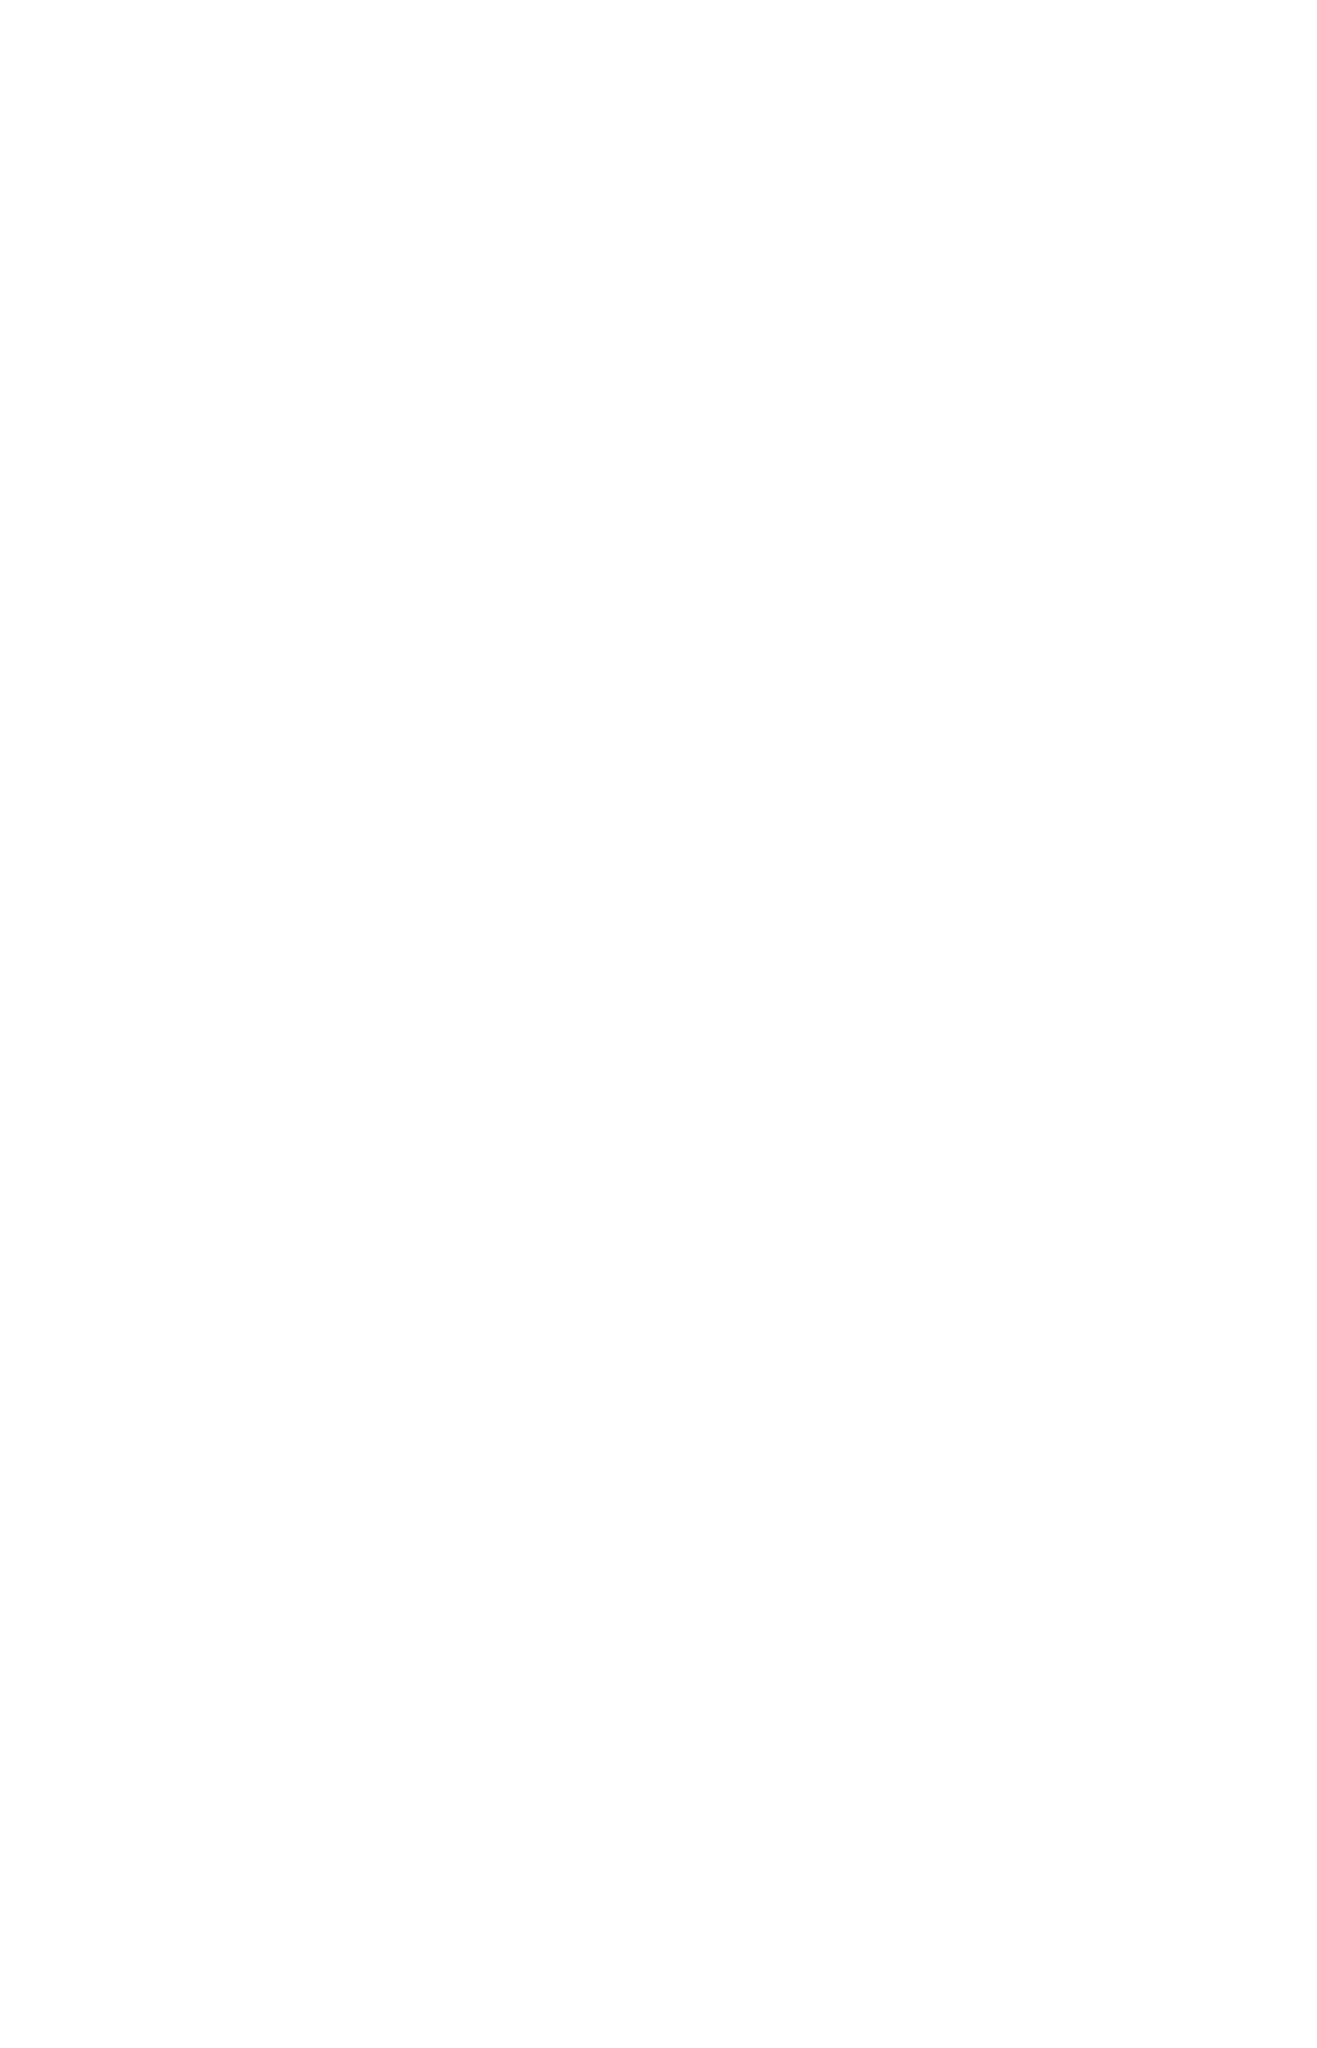

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=8192).create(prog='dot', format='svg'))

### Transposed Convolution Code

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
# input data

X = np.asarray([[1, 2], [3, 4]])

In [ ]:
print(X)
print(X.shape)

[[1 2]
 [3 4]]
(2, 2)


In [ ]:
X = X.reshape((1, 2, 2, 1))

In [ ]:
print(X)
print(X.shape)

[[[[1]
   [2]]

  [[3]
   [4]]]]
(1, 2, 2, 1)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2DTranspose(1, (1, 1), strides=(2, 2), input_shape=(2, 2, 1))) # Conv2DTranspos layer

In [ ]:
weights = [np.asarray([[[[1]]]]), np.asarray([1])] # weight = 1, bias = 1

In [ ]:
weights

[array([[[[1]]]]), array([1])]

In [ ]:
model.set_weights(weights)

In [ ]:
yhat = model.predict(X)
yhat = yhat.reshape((4, 4))
print(yhat)

[[2. 1. 3. 1.]
 [1. 1. 1. 1.]
 [4. 1. 5. 1.]
 [1. 1. 1. 1.]]
